# Synthetic Data Balanced + Features added for training - testing, raw real data with feature added and balanced real data for testing

### import libraries and read data files

In [1]:
from ctgan import CTGAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#define data for each scenarios with data paths
balanced_synthetic_data = pd.read_csv("../Data/balanced_synthetic_data_scenario3.csv")
feature_df = pd.read_csv("../Data/preprocessed_df_scenario3.csv")
balanced_feature_df = pd.read_csv("../Data/balanced_feature_df_scenario3.csv")

# RF

In [ ]:
#import libraries
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib  

#train-test split 7/3
#split the data into training and testing sets
X, y = balanced_synthetic_data.drop("Label", axis=1), balanced_synthetic_data.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#scale the data (fit on training set and transform both training and test sets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#RANDOM FOREST

# objective function for Optuna with RandomForestClassifier
def objective(trial):
    #suggest hyperparameters for RandomForestClassifier (range)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)  # Adjust range as needed
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # initialize the RandomForestClassifier with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1  # Enable parallel processing
    )

    #use KFold cross-validation (5-fold)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_aucs = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)

    #report the mean ROC-AUC score across all folds
    return roc_aucs.mean()

#set up the Optuna study with pruning enabled, 200 trials (early stop consume more time and gpus)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=200)  # Adjust n_trials as needed

#print the best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the test data
best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")


[I 2024-11-27 17:21:35,242] A new study created in memory with name: no-name-900b0481-1ba1-4a3c-a637-ec21b5379fbb
[I 2024-11-27 17:21:48,593] Trial 0 finished with value: 0.8000569359332499 and parameters: {'n_estimators': 133, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8000569359332499.
[I 2024-11-27 17:22:02,149] Trial 1 finished with value: 0.7855231199528949 and parameters: {'n_estimators': 378, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8000569359332499.
[I 2024-11-27 17:22:16,130] Trial 2 finished with value: 0.8420497235571267 and parameters: {'n_estimators': 365, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.8420497235571267.
[I 2024-11-27 17:22:24,975] Trial 3 finished with value: 0.849403701847241 and

Best hyperparameters: {'n_estimators': 264, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Best cross-validated ROC-AUC score: 0.8877615633509557
Test ROC-AUC score: 0.8889091629292968
Test Accuracy: 0.8230


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# X and y: synthetic features and labels
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the best model with the best hyperparameters found by Optuna
#best_model = RandomForestClassifier(**best_params, random_state=42)

# Fit the best model on the training data
#best_model.fit(X_train_scaled, y_train)

#TEST ON SYNTHETIC DATA SPLITTED AND SCALED

#evaluate the model on the test data, for each model, change best_model from 1 to 5
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model.predict(X_test_scaled)))

#generate the confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test_scaled))

#extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

#calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

#print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2439
           1       0.81      0.86      0.83      2538

    accuracy                           0.82      4977
   macro avg       0.82      0.82      0.82      4977
weighted avg       0.82      0.82      0.82      4977

False Positive Rate (FPR): 0.2161

Confusion Matrix Scores:
True Positives (TP): 2184
True Negatives (TN): 1912
False Positives (FP): 527
False Negatives (FN): 354


In [ ]:
#TEST ON REAL DATASET, for each scenario, change test data file name correspondingly. for each model, change best_model from 1 to 5.

#evaluate the model on the test data
X_test, y_test = balanced_feature_df.drop("Label", axis=1), balanced_feature_df.Label

#scale the real test data using the same scaler
X_real_scaled = scaler.transform(balanced_feature_df.drop("Label", axis=1))
print(classification_report(y_test, best_model.predict(X_real_scaled)))
#generate the confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_real_scaled))

#extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

#calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

#print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        48
           1       0.71      0.81      0.76        48

    accuracy                           0.74        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.74      0.74      0.74        96

False Positive Rate (FPR): 0.3333

Confusion Matrix Scores:
True Positives (TP): 39
True Negatives (TN): 32
False Positives (FP): 16
False Negatives (FN): 9


In [ ]:
import joblib 
joblib.dump(best_model1,"RF_model_case1.pkl")

['RF_model2.pkl']

### XGB

In [3]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Split the data into training and testing sets
X, y = synthetic_data.drop("Label", axis=1), synthetic_data.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features once for both training and testing sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#XGBOOST


#objective function for Optuna with XGBClassifier
def objective(trial):
    #suggest hyperparameters for XGBClassifier
    n_estimators = trial.suggest_int("n_estimators", 20, 300)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)

    #initialize the XGBClassifier with the suggested hyperparameters
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    #set up StratifiedKFold cross-validation (5-fold)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    #cross-validation and calculate ROC-AUC score
    roc_aucs = []
    for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
        X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        #fit the model and calculate ROC-AUC for each fold
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        roc_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_aucs.append(roc_auc)
        
        #report intermediate values for pruning with the fold number as the step
        trial.report(np.mean(roc_aucs), fold)
        
        #check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    #return the mean ROC-AUC across all folds
    return np.mean(roc_aucs)

#set up the Optuna study with a pruner
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=200)  # Adjust n_trials as needed

#print best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the test data (best_model2)
best_model2 = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model2.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model2.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model2.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")


[I 2024-11-29 11:04:40,844] A new study created in memory with name: no-name-fa597e1b-aac5-4e63-8260-d3809788094a
[I 2024-11-29 11:04:41,287] Trial 0 finished with value: 0.5459630859598563 and parameters: {'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.02737889884951345, 'subsample': 0.924132270937429, 'colsample_bytree': 0.9693131343734434, 'gamma': 3.9093524724951134, 'min_child_weight': 7}. Best is trial 0 with value: 0.5459630859598563.
[I 2024-11-29 11:04:41,975] Trial 1 finished with value: 0.5212405340861647 and parameters: {'n_estimators': 291, 'max_depth': 10, 'learning_rate': 0.24732504206775352, 'subsample': 0.5410047106264154, 'colsample_bytree': 0.6950722727263954, 'gamma': 2.0719187735115465, 'min_child_weight': 8}. Best is trial 0 with value: 0.5459630859598563.
[I 2024-11-29 11:04:42,609] Trial 2 finished with value: 0.5428608191831735 and parameters: {'n_estimators': 237, 'max_depth': 5, 'learning_rate': 0.04300758140981873, 'subsample': 0.5394912528440123, '

Best hyperparameters: {'n_estimators': 85, 'max_depth': 6, 'learning_rate': 0.04974105973401808, 'subsample': 0.710677147966072, 'colsample_bytree': 0.8002264325986135, 'gamma': 4.70986720699052, 'min_child_weight': 10}
Best cross-validated ROC-AUC score: 0.5679063709636174
Test ROC-AUC score: 0.5428334367245657
Test Accuracy: 0.8267


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the best model with the best hyperparameters found by Optuna
#best_model2 = XGBClassifier(**best_params, random_state=42)

# Fit the best model on the training data
#best_model2.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model2.predict(X_test_scaled)))

# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model2.predict(X_test_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       520
           1       0.83      1.00      0.91      2480

    accuracy                           0.83      3000
   macro avg       0.41      0.50      0.45      3000
weighted avg       0.68      0.83      0.75      3000

False Positive Rate (FPR): 1.0000

Confusion Matrix Scores:
True Positives (TP): 2480
True Negatives (TN): 0
False Positives (FP): 520
False Negatives (FN): 0


In [10]:
from sklearn.metrics import classification_report

# Evaluate the model on the test data
X_test, y_test = feature_df.drop("Label", axis=1), feature_df.Label
# Scale the real test data using the same scaler
X_real_scaled = scaler.transform(feature_df.drop("Label", axis=1))

print(classification_report(y_test, best_model2.predict(X_real_scaled)))

# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model2.predict(X_real_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.80      1.00      0.89        48

    accuracy                           0.80        60
   macro avg       0.40      0.50      0.44        60
weighted avg       0.64      0.80      0.71        60

False Positive Rate (FPR): 1.0000

Confusion Matrix Scores:
True Positives (TP): 48
True Negatives (TN): 0
False Positives (FP): 12
False Negatives (FN): 0


In [49]:
import joblib 
joblib.dump(best_model2,"XGB_model1.pkl")

['XGB_model1.pkl']

### LOG REG

In [11]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X, y = synthetic_data.drop("Label", axis=1), synthetic_data.Label
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled))
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled))


#LOG REG


#objective function for Optuna with Logistic Regression
def objective(trial):
    #suggest hyperparameters for Logistic Regression
    C = trial.suggest_loguniform("C", 1e-4, 1e2)  
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"]) 
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"]) if solver in ["liblinear", "saga"] else "l2"

    #initialize the Logistic Regression model with suggested hyperparameters
    model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        max_iter=1000,
        random_state=42
    )

    #set up Stratified K-Fold cross-validation (5-fold)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_aucs = []

    #cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled, y_train)):
        X_fold_train, X_fold_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        #fit the model and calculate ROC-AUC for each fold
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        roc_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_aucs.append(roc_auc)

        #report intermediate values for pruning
        intermediate_value = sum(roc_aucs) / len(roc_aucs)
        trial.report(intermediate_value, fold)

        #check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    #return the mean ROC-AUC across all folds if not pruned
    return sum(roc_aucs) / len(roc_aucs)

#set up the Optuna study with a pruner
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=300)  # Adjust n_trials as needed

#print the best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the scaled test data (best_model3)
best_model3 = LogisticRegression(**best_params, max_iter=1000, random_state=42)
best_model3.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model3.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model3.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")


[I 2024-11-29 11:11:34,824] A new study created in memory with name: no-name-1369a615-f918-456c-8af4-2cd8d3f82536
[I 2024-11-29 11:11:34,972] Trial 0 finished with value: 0.5 and parameters: {'C': 0.004856831254434025, 'solver': 'saga', 'penalty': 'l1'}. Best is trial 0 with value: 0.5.
[I 2024-11-29 11:11:35,066] Trial 1 finished with value: 0.5651272441587954 and parameters: {'C': 0.0001654732011724237, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5651272441587954.
[I 2024-11-29 11:11:35,116] Trial 2 finished with value: 0.5638644536718107 and parameters: {'C': 0.005244232921880164, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5651272441587954.
[I 2024-11-29 11:11:35,181] Trial 3 finished with value: 0.5651151855982572 and parameters: {'C': 0.0006173453057168465, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.5651272441587954.
[I 2024-11-29 11:11:35,237] Trial 4 finished with value: 0.5634381846047034 and parameters: {'C': 0.0316770602128104, 'solver

Best hyperparameters: {'C': 0.00010241971353372532, 'solver': 'liblinear', 'penalty': 'l2'}
Best cross-validated ROC-AUC score: 0.565739167086993
Test ROC-AUC score: 0.5483157568238213
Test Accuracy: 0.8267


In [12]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# X and y: synthetic features and labels
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the best model with the best hyperparameters found by Optuna
#best_model3 = LogisticRegression(**best_params, random_state=42)

# Fit the best model on the training data
#best_model3.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model3.predict(X_test_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model3.predict(X_test_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       520
           1       0.83      1.00      0.91      2480

    accuracy                           0.83      3000
   macro avg       0.41      0.50      0.45      3000
weighted avg       0.68      0.83      0.75      3000

False Positive Rate (FPR): 1.0000

Confusion Matrix Scores:
True Positives (TP): 2480
True Negatives (TN): 0
False Positives (FP): 520
False Negatives (FN): 0


In [13]:
# Evaluate the model on the test data

X_test, y_test = feature_df.drop("Label", axis=1), feature_df.Label
# Scale the real test data using the same scaler
X_real_scaled = scaler.transform(feature_df.drop("Label", axis=1))

print(classification_report(y_test, best_model3.predict(X_real_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model3.predict(X_real_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.80      1.00      0.89        48

    accuracy                           0.80        60
   macro avg       0.40      0.50      0.44        60
weighted avg       0.64      0.80      0.71        60

False Positive Rate (FPR): 1.0000

Confusion Matrix Scores:
True Positives (TP): 48
True Negatives (TN): 0
False Positives (FP): 12
False Negatives (FN): 0


In [92]:
import joblib 
joblib.dump(best_model3,"Logreg_model1.pkl")

['Logreg_model1.pkl']

### Dec tree

In [4]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.feature_selection import RFE

# Split the data into training and testing sets
X, y = balanced_synthetic_data.drop("Label", axis=1), balanced_synthetic_data.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

# DECISION TREE


#objective function for Optuna with Decision Tree
def objective(trial):
    #suggest hyperparameters for Decision Tree
    max_depth = trial.suggest_int("max_depth", 2, 100)  # Expanded max_depth range
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100)  # Expanded range
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)  # Expanded range
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])  # Added "auto" and fraction
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    #initialize the Decision Tree model with suggested hyperparameters
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        class_weight='balanced',
        random_state=42
    )

    #stratified K-Fold cross-validation (5-fold)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_aucs = []
    f1_scores = []

    #cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled, y_train)):
        X_fold_train, X_fold_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        #fit the model and calculate ROC-AUC and F1-score for each fold
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_fold_val)
        
        roc_auc = roc_auc_score(y_fold_val, y_pred_proba)
        f1 = f1_score(y_fold_val, model.predict(X_fold_val))

        roc_aucs.append(roc_auc)
        f1_scores.append(f1)

    #return the mean ROC-AUC across all folds
    return sum(roc_aucs) / len(roc_aucs)

#set up the Optuna study (no pruning)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=300)  
#print the best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the test data (best_model4)
best_model4 = DecisionTreeClassifier(**best_params, random_state=42)
best_model4.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model4.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model4, "predict_proba") else best_model.predict(X_test_scaled)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model4.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")


[I 2024-11-28 20:04:08,866] A new study created in memory with name: no-name-f7aea72e-ddc8-454e-a096-25f0412ccca4


[I 2024-11-28 20:04:09,064] Trial 0 finished with value: 0.7354797128143922 and parameters: {'max_depth': 50, 'min_samples_split': 79, 'min_samples_leaf': 40, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.7354797128143922.
[I 2024-11-28 20:04:09,304] Trial 1 finished with value: 0.8256128664388198 and parameters: {'max_depth': 20, 'min_samples_split': 67, 'min_samples_leaf': 33, 'max_features': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8256128664388198.
[I 2024-11-28 20:04:09,408] Trial 2 finished with value: 0.6551653867711161 and parameters: {'max_depth': 3, 'min_samples_split': 58, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.8256128664388198.
[I 2024-11-28 20:04:09,589] Trial 3 finished with value: 0.82102643884472 and parameters: {'max_depth': 71, 'min_samples_split': 43, 'min_samples_leaf': 30, 'max_features': None, 'criterion': 'gini'}. Best is trial 1 with value: 0.82561286643

Best hyperparameters: {'max_depth': 78, 'min_samples_split': 48, 'min_samples_leaf': 23, 'max_features': None, 'criterion': 'entropy'}
Best cross-validated ROC-AUC score: 0.832740044793864
Test ROC-AUC score: 0.8258500357600654
Test Accuracy: 0.7633
Test F1-Score: 0.7852


In [259]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Initialize the best model with the best hyperparameters found by Optuna
#best_model4 = DecisionTreeClassifier(**best_params, random_state=42)

# Fit the best model on the training data
#best_model4.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model4.predict(X_test_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model4.predict(X_test_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      2390
           1       0.69      0.73      0.71      2422

    accuracy                           0.70      4812
   macro avg       0.70      0.70      0.70      4812
weighted avg       0.70      0.70      0.70      4812

False Positive Rate (FPR): 0.3423

Confusion Matrix Scores:
True Positives (TP): 1779
True Negatives (TN): 1572
False Positives (FP): 818
False Negatives (FN): 643


In [6]:
from sklearn.metrics import classification_report

X_test, y_test = balanced_feature_df.drop("Label", axis=1), balanced_feature_df.Label
# Scale the real test data using the same scaler
X_real_scaled = scaler.transform(balanced_feature_df.drop("Label", axis=1))

print(classification_report(y_test, best_model4.predict(X_real_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model4.predict(X_real_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


              precision    recall  f1-score   support

           0       0.88      0.73      0.80        48
           1       0.77      0.90      0.83        48

    accuracy                           0.81        96
   macro avg       0.82      0.81      0.81        96
weighted avg       0.82      0.81      0.81        96



NameError: name 'confusion_matrix' is not defined

In [ ]:
#tree visualisation
dot_data = tree.export_graphviz(best_model4, out_file=None)
graph = graphviz.Source(dot_data) 
graph.render("dec_tree")

In [27]:

import joblib 
joblib.dump(best_model4,"DT_model1.pkl")

              precision    recall  f1-score   support

           0       0.20      0.08      0.12        12
           1       0.80      0.92      0.85        48

    accuracy                           0.75        60
   macro avg       0.50      0.50      0.49        60
weighted avg       0.68      0.75      0.71        60



['DT_model1.pkl']

### For READING PKL files

In [46]:
pklread1 = joblib.load("DT_model1.pkl")
y_pred = pklread1.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.08      0.12        12
           1       0.80      0.92      0.85        48

    accuracy                           0.75        60
   macro avg       0.50      0.50      0.49        60
weighted avg       0.68      0.75      0.71        60



### LightGBM

In [3]:
import optuna
from lightgbm import LGBMClassifier
import logging
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np




# Split the data into training and testing sets
X, y = balanced_synthetic_data.drop("Label", axis=1), balanced_synthetic_data["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features once for both training and testing sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#LIGHTGBM

#enable logging for better visibility during training
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#objective function for Optuna with LGBMClassifier
def objective(trial):
    #suggest hyperparameters for LGBMClassifier
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 10, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "random_state": 42,
        "n_jobs": -1,
    }

    #initialize the LGBMClassifier with the suggested hyperparameters
    model = LGBMClassifier(**params)

    #set up StratifiedKFold cross-validation (5-fold)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    #cross-validation and calculate ROC-AUC score
    roc_aucs = []
    for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
        X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        #fit the model and calculate ROC-AUC for each fold
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        roc_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_aucs.append(roc_auc)
        
        #report intermediate values for pruning with the fold number as the step
        trial.report(np.mean(roc_aucs), step=fold)
        
        #check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Return the mean ROC-AUC across all folds
    mean_roc_auc = np.mean(roc_aucs)
    logger.info(f"Trial {trial.number}: Mean ROC-AUC = {mean_roc_auc:.4f}")
    return mean_roc_auc

#set up the Optuna study with a pruner
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=100, show_progress_bar=True)  # Adjust n_trials as needed

#print the best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the test data (best_model5)
best_model5 = LGBMClassifier(**best_params, random_state=42)
best_model5.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model5.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model5.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Feature Importance Analysis
importances = best_model5.feature_importances_
feature_names = X.columns
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


[I 2024-12-05 01:27:20,617] A new study created in memory with name: no-name-b6170fbe-acae-4e92-b1ed-416fb96c86f9


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

INFO:__main__:Trial 0: Mean ROC-AUC = 0.8382


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 1: Mean ROC-AUC = 0.8469


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 2: Mean ROC-AUC = 0.8206


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 3: Mean ROC-AUC = 0.8803


[LightGBM] [Info] Number of positive: 4491, number of negative: 4492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499944 -> initscore=-0.000223
[LightGBM] [Info] Start training from score -0.000223
[I 2024-12-05 01:27:24,399] Trial 3 finished with value: 0.8802670882700528 and parameters: {'num_leaves': 39, 'max_depth': 14, 'learning_rate': 0.2750142056141436, 'n_estimators': 156, 'min_child_samples': 38, 'subsample': 0.9329921283411563, 'colsample_bytree': 0.8245277202084025, 'reg_alpha': 1.1183237350089792, 'reg_lambda': 5.880551477908029}. Best is trial 3 with value: 0.8802670882700528.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise m

INFO:__main__:Trial 4: Mean ROC-AUC = 0.8255


[I 2024-12-05 01:27:25,932] Trial 4 finished with value: 0.8254693260595068 and parameters: {'num_leaves': 147, 'max_depth': 8, 'learning_rate': 0.010630888614328341, 'n_estimators': 246, 'min_child_samples': 45, 'subsample': 0.5835579928809209, 'colsample_bytree': 0.7095458571282396, 'reg_alpha': 7.974893906197309, 'reg_lambda': 6.43149469861119}. Best is trial 3 with value: 0.8802670882700528.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

INFO:__main__:Trial 5: Mean ROC-AUC = 0.8755


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 6: Mean ROC-AUC = 0.8826


[I 2024-12-05 01:27:29,829] Trial 6 finished with value: 0.8825641008940679 and parameters: {'num_leaves': 82, 'max_depth': 11, 'learning_rate': 0.08316234179462137, 'n_estimators': 185, 'min_child_samples': 22, 'subsample': 0.554466117670982, 'colsample_bytree': 0.8588598573870914, 'reg_alpha': 0.9205265857410827, 'reg_lambda': 1.347014381611622}. Best is trial 6 with value: 0.8825641008940679.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

INFO:__main__:Trial 7: Mean ROC-AUC = 0.8774


[LightGBM] [Info] Number of positive: 4491, number of negative: 4492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499944 -> initscore=-0.000223
[LightGBM] [Info] Start training from score -0.000223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

INFO:__main__:Trial 9: Mean ROC-AUC = 0.8805


[LightGBM] [Info] Number of positive: 4491, number of negative: 4492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499944 -> initscore=-0.000223
[LightGBM] [Info] Start training from score -0.000223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

INFO:__main__:Trial 10: Mean ROC-AUC = 0.8788


[I 2024-12-05 01:27:34,829] Trial 10 finished with value: 0.8788149133875487 and parameters: {'num_leaves': 31, 'max_depth': 11, 'learning_rate': 0.13609609377826376, 'n_estimators': 206, 'min_child_samples': 22, 'subsample': 0.6719609212671251, 'colsample_bytree': 0.9829674922691933, 'reg_alpha': 0.038645763677317646, 'reg_lambda': 0.01903393442761825}. Best is trial 6 with value: 0.8825641008940679.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

INFO:__main__:Trial 12: Mean ROC-AUC = 0.8782


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 16: Mean ROC-AUC = 0.8813


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:27:43,09

INFO:__main__:Trial 17: Mean ROC-AUC = 0.8804


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 19: Mean ROC-AUC = 0.8808


[I 2024-12-05 01:27:48,567] Trial 19 finished with value: 0.8808459360980951 and parameters: {'num_leaves': 81, 'max_depth': 12, 'learning_rate': 0.09521160695595583, 'n_estimators': 209, 'min_child_samples': 25, 'subsample': 0.7704996900220855, 'colsample_bytree': 0.5829853533379368, 'reg_alpha': 1.7813970608250407, 'reg_lambda': 4.203954563634005}. Best is trial 6 with value: 0.8825641008940679.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

INFO:__main__:Trial 20: Mean ROC-AUC = 0.8804


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 21: Mean ROC-AUC = 0.8814


[I 2024-12-05 01:27:53,076] Trial 21 finished with value: 0.8814035338329793 and parameters: {'num_leaves': 86, 'max_depth': 12, 'learning_rate': 0.1025021809750041, 'n_estimators': 205, 'min_child_samples': 25, 'subsample': 0.7863112101127593, 'colsample_bytree': 0.6245906323127326, 'reg_alpha': 1.8749910735821418, 'reg_lambda': 3.992031535351325}. Best is trial 6 with value: 0.8825641008940679.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

INFO:__main__:Trial 22: Mean ROC-AUC = 0.8809


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 23: Mean ROC-AUC = 0.8807


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 24: Mean ROC-AUC = 0.8828


[I 2024-12-05 01:27:59,029] Trial 24 finished with value: 0.8828475014300805 and parameters: {'num_leaves': 83, 'max_depth': 14, 'learning_rate': 0.10350607816411933, 'n_estimators': 153, 'min_child_samples': 18, 'subsample': 0.7224156789636923, 'colsample_bytree': 0.6473811436389576, 'reg_alpha': 0.8111522145496768, 'reg_lambda': 1.0417490339867026}. Best is trial 24 with value: 0.8828475014300805.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosi

INFO:__main__:Trial 27: Mean ROC-AUC = 0.8814


[I 2024-12-05 01:28:03,000] Trial 27 finished with value: 0.881375233638409 and parameters: {'num_leaves': 120, 'max_depth': 14, 'learning_rate': 0.06384720523390079, 'n_estimators': 139, 'min_child_samples': 23, 'subsample': 0.7095804341336769, 'colsample_bytree': 0.7379670090200869, 'reg_alpha': 2.0259609577011073, 'reg_lambda': 2.3135069410733524}. Best is trial 24 with value: 0.8828475014300805.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

INFO:__main__:Trial 31: Mean ROC-AUC = 0.8810


[I 2024-12-05 01:28:08,951] Trial 31 finished with value: 0.8809602587243471 and parameters: {'num_leaves': 140, 'max_depth': 14, 'learning_rate': 0.062424084701496525, 'n_estimators': 141, 'min_child_samples': 22, 'subsample': 0.708478781550044, 'colsample_bytree': 0.7326704919146447, 'reg_alpha': 1.7550285010335187, 'reg_lambda': 2.2664446977740678}. Best is trial 24 with value: 0.8828475014300805.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

INFO:__main__:Trial 32: Mean ROC-AUC = 0.8843


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:11,444] Trial 32 finished with value: 0.8843255063779969 and parameters: {'num_leaves': 111, 'max_depth': 14, 'learning_rate': 0.07474087216890195, 'n_estimators': 176, 'min_child_samples': 19, 'subsample': 0.7337630639669587, 'colsample_bytree': 0.7804186236851255, 'reg_alpha': 1.9914295234742665, 'reg_lambda': 2.2401777107428384}. Best is trial 32 with value: 0.88432550637799

INFO:__main__:Trial 33: Mean ROC-AUC = 0.8811


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:13,423] Trial 33 finished with value: 0.8810532690660455 and parameters: {'num_leaves': 79, 'max_depth': 12, 'learning_rate': 0.07539771357869483, 'n_estimators': 173, 'min_child_samples': 18, 'subsample': 0.8031565565827911, 'colsample_bytree': 0.7824554945626367, 'reg_alpha': 3.118086513378807, 'reg_lambda': 0.8924777921188853}. Best is trial 32 with value: 0.8843255063779969.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testi

INFO:__main__:Trial 34: Mean ROC-AUC = 0.8850


[I 2024-12-05 01:28:15,707] Trial 34 finished with value: 0.8850021549813281 and parameters: {'num_leaves': 111, 'max_depth': 14, 'learning_rate': 0.09906072629211443, 'n_estimators': 148, 'min_child_samples': 20, 'subsample': 0.7530518130092998, 'colsample_bytree': 0.8589532721071372, 'reg_alpha': 0.8466210299442529, 'reg_lambda': 3.2668936257530152}. Best is trial 34 with value: 0.8850021549813281.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

INFO:__main__:Trial 35: Mean ROC-AUC = 0.8861


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:18,438] Trial 35 finished with value: 0.8860556977177831 and parameters: {'num_leaves': 138, 'max_depth': 14, 'learning_rate': 0.1611507753121998, 'n_estimators': 152, 'min_child_samples': 12, 'subsample': 0.7408963137710417, 'colsample_bytree': 0.8563613631005683, 'reg_alpha': 0.8886855018305936, 'reg_lambda': 3.2149841744787335}. Best is trial 35 with value: 0.8860556977177831.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

INFO:__main__:Trial 36: Mean ROC-AUC = 0.8863


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:21,302] Trial 36 finished with value: 0.8863476836346151 and parameters: {'num_leaves': 138, 'max_depth': 14, 'learning_rate': 0.19431136757076733, 'n_estimators': 152, 'min_child_samples': 11, 'subsample': 0.7424705263815458, 'colsample_bytree': 0.9029284761322194, 'reg_alpha': 0.6005954385649059, 'reg_lambda': 3.1986747150030177}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in 

INFO:__main__:Trial 38: Mean ROC-AUC = 0.8850


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:23,556] Trial 38 finished with value: 0.8850391276246719 and parameters: {'num_leaves': 149, 'max_depth': 15, 'learning_rate': 0.15597303868734103, 'n_estimators': 90, 'min_child_samples': 12, 'subsample': 0.8275807377165111, 'colsample_bytree': 0.8157267905350745, 'reg_alpha': 1.27979938333851, 'reg_lambda': 2.696200453003067}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No fu

INFO:__main__:Trial 39: Mean ROC-AUC = 0.8845


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:25,449] Trial 39 finished with value: 0.8844643408947626 and parameters: {'num_leaves': 149, 'max_depth': 15, 'learning_rate': 0.15728212406207212, 'n_estimators': 87, 'min_child_samples': 12, 'subsample': 0.8346963962817823, 'colsample_bytree': 0.8274135034528216, 'reg_alpha': 0.450540233603794, 'reg_lambda': 4.8158724821808825}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in th

INFO:__main__:Trial 41: Mean ROC-AUC = 0.8863


[I 2024-12-05 01:28:27,607] Trial 41 finished with value: 0.8863436915123936 and parameters: {'num_leaves': 147, 'max_depth': 15, 'learning_rate': 0.16833675780190105, 'n_estimators': 96, 'min_child_samples': 12, 'subsample': 0.8351609344417776, 'colsample_bytree': 0.8278647438739066, 'reg_alpha': 1.3285463515475875, 'reg_lambda': 4.674468490405159}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 42: Mean ROC-AUC = 0.8850


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:29,554] Trial 42 finished with value: 0.8850339118867417 and parameters: {'num_leaves': 142, 'max_depth': 15, 'learning_rate': 0.19895337516876033, 'n_estimators': 100, 'min_child_samples': 10, 'subsample': 0.7931309076015373, 'colsample_bytree': 0.8559647390378309, 'reg_alpha': 1.2155743354244073, 'reg_lambda': 3.543248815818499}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:B

INFO:__main__:Trial 43: Mean ROC-AUC = 0.8854


[I 2024-12-05 01:28:31,500] Trial 43 finished with value: 0.8853507574005262 and parameters: {'num_leaves': 143, 'max_depth': 15, 'learning_rate': 0.2040820452471265, 'n_estimators': 100, 'min_child_samples': 10, 'subsample': 0.8367095926407867, 'colsample_bytree': 0.9468661812971539, 'reg_alpha': 1.2509190020827163, 'reg_lambda': 6.003913959595552}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 45: Mean ROC-AUC = 0.8851


[I 2024-12-05 01:28:34,308] Trial 45 finished with value: 0.8850772182996953 and parameters: {'num_leaves': 145, 'max_depth': 13, 'learning_rate': 0.2491742274690403, 'n_estimators': 96, 'min_child_samples': 12, 'subsample': 0.8946378256309203, 'colsample_bytree': 0.8887183733345368, 'reg_alpha': 1.428874309194062, 'reg_lambda': 5.327063494997972}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

INFO:__main__:Trial 46: Mean ROC-AUC = 0.8844


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 47: Mean ROC-AUC = 0.8841


[I 2024-12-05 01:28:37,979] Trial 47 finished with value: 0.8840641508542534 and parameters: {'num_leaves': 142, 'max_depth': 13, 'learning_rate': 0.19742734487417166, 'n_estimators': 98, 'min_child_samples': 10, 'subsample': 0.8980854959427822, 'colsample_bytree': 0.9003390002338342, 'reg_alpha': 0.027505697363936488, 'reg_lambda': 5.3762365627676045}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

INFO:__main__:Trial 49: Mean ROC-AUC = 0.8838


[I 2024-12-05 01:28:39,755] Trial 49 finished with value: 0.883774562274378 and parameters: {'num_leaves': 143, 'max_depth': 15, 'learning_rate': 0.2932062015335613, 'n_estimators': 71, 'min_child_samples': 12, 'subsample': 0.8747954104473263, 'colsample_bytree': 0.9382717327839563, 'reg_alpha': 0.4161548148145417, 'reg_lambda': 6.397035904946489}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

INFO:__main__:Trial 51: Mean ROC-AUC = 0.8855


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:42,389] Trial 51 finished with value: 0.8855050542530243 and parameters: {'num_leaves': 146, 'max_depth': 15, 'learning_rate': 0.1675579687306815, 'n_estimators': 110, 'min_child_samples': 12, 'subsample': 0.8404116774082575, 'col

INFO:__main__:Trial 52: Mean ROC-AUC = 0.8844


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:44,970] Trial 52 finished with value: 0.8844154423445911 and parameters: {'num_leaves': 134, 'max_depth': 14, 'learning_rate': 0.17214701156456882, 'n_estimators': 110, 'min_child_samples': 11, 'subsample': 0.8498094460146984, 'colsample_bytree': 0.8830752060777333, 'reg_alpha': 1.4940465964527325, 'reg_lambda': 5.258686572203896}. Best is trial 36 with value: 0.8863476836346151.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

INFO:__main__:Trial 53: Mean ROC-AUC = 0.8865


[I 2024-12-05 01:28:47,229] Trial 53 finished with value: 0.8864984748712184 and parameters: {'num_leaves': 139, 'max_depth': 15, 'learning_rate': 0.21301295387805647, 'n_estimators': 115, 'min_child_samples': 15, 'subsample': 0.8796511643874477, 'colsample_bytree': 0.925570391499447, 'reg_alpha': 1.111751332381814, 'reg_lambda': 6.105701651394338}. Best is trial 53 with value: 0.8864984748712184.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 54: Mean ROC-AUC = 0.8867


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:49,275] Trial 54 finished with value: 0.8867139908133895 and parameters: {'num_leaves': 138, 'max_depth': 15, 'learning_rate': 0.2083577457602271, 'n_estimators': 114, 'min_child_samples': 15, 'subsample': 0.7734862069987023, 'colsample_bytree': 0.8015969812598887, 'reg_alpha': 0.40115168642859556, 'reg_lambda': 6.822111666417448}. Best is trial 54 with value: 0.8867139908133895.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

INFO:__main__:Trial 55: Mean ROC-AUC = 0.8864


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:51,271] Trial 55 finished with value: 0.8864193252954713 and parameters: {'num_l

INFO:__main__:Trial 56: Mean ROC-AUC = 0.8844


[I 2024-12-05 01:28:53,025] Trial 56 finished with value: 0.8843723954393697 and parameters: {'num_leaves': 118, 'max_depth': 14, 'learning_rate': 0.13455397150873533, 'n_estimators': 116, 'min_child_samples': 16, 'subsample': 0.6928048515881212, 'colsample_bytree': 0.7990961083096622, 'reg_alpha': 0.39421684629754494, 'reg_lambda': 6.729725185953945}. Best is trial 54 with value: 0.8867139908133895.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

INFO:__main__:Trial 57: Mean ROC-AUC = 0.8870


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:55,555] Trial 57 finished with value: 0.8869819975655491 and parameters: {'num_leaves': 128, 'max_depth': 15, 'learning_rate': 0.22976922773071592, 'n_estimators': 133, 'min_child_samples': 15, 'subsample': 0.7686588325046401, 'colsample_bytree': 0.8369376200796771, 'reg_alpha': 0.9779921030629867, 'reg_lambda': 7.717855228654407}. Best is trial 57 with value: 0.8869819975655491.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in t

INFO:__main__:Trial 58: Mean ROC-AUC = 0.8844


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:28:57,852] Trial 58 finished with value: 0.8843930661631403 and parameters: {'num_leaves': 128, 'max_depth': 15, 'learning_rate': 0.22164634734376176, 'n_estimators': 132, 'min_child_samples': 15, 'subsample': 0.7689088018264656, 'colsample_bytree': 0.764130656559199, 'reg_alpha': 0.06125944585875298, 'reg_lambda': 7.902538998863805}. Best is trial 57 with value: 0.8869819975655491.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[Li

INFO:__main__:Trial 62: Mean ROC-AUC = 0.8839


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 63: Mean ROC-AUC = 0.8865


[I 2024-12-05 01:29:04,230] Trial 63 finished with value: 0.8865371495799842 and parameters: {'num_leaves': 122, 'max_depth': 15, 'learning_rate': 0.14605796765594864, 'n_estimators': 149, 'min_child_samples': 13, 'subsample': 0.7398683753895854, 'colsample_bytree': 0.8745548602705889, 'reg_alpha': 0.3848857347775008, 'reg_lambda': 8.07861264468903}. Best is trial 57 with value: 0.8869819975655491.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

INFO:__main__:Trial 64: Mean ROC-AUC = 0.8849


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:29:06,254] Trial 64 finished with value: 0.884941407556853 and parameters: {'num_leaves': 120, 'max_depth': 15, 'learning_rate': 0.19160579020561957, 'n_estimators': 125, 'min_child_samples': 15, 'subsample': 0.7677694794278016, 'colsample_bytree': 0.7558119122541419, 'reg_alpha': 0.3222552445892656, 'reg_lambda': 8.197017167946335}. Best is trial 57 with value: 0.8869819975655491.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No 

INFO:__main__:Trial 66: Mean ROC-AUC = 0.8843


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:29:09,687] Trial 66 finished with value: 0.8843217782865185 and parameters: {'num_leaves': 125, 'max_depth': 14, 'learning_rate': 0.14510242192643216, 'n_estimators': 146, 'min_child_samples': 17, 'subsample': 0.7234209483515481, 'colsample_bytree': 0.7971698824435852, 'reg_alpha': 1.6221550292822873, 'reg_

INFO:__main__:Trial 67: Mean ROC-AUC = 0.8858


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 69: Mean ROC-AUC = 0.8871


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:29:15,647] Trial 69 finished with value: 0.8871460540854906 and parameters: {'num_leaves': 128, 'max_depth': 14, 'learning_rate': 0.21044445758314714, 'n_estimators': 174, 'min_child_samples': 21, 'subsample': 0.818978942458969, 'col

INFO:__main__:Trial 71: Mean ROC-AUC = 0.8858


[I 2024-12-05 01:29:19,515] Trial 71 finished with value: 0.8857706561769909 and parameters: {'num_leaves': 126, 'max_depth': 15, 'learning_rate': 0.21707307122559133, 'n_estimators': 116, 'min_child_samples': 17, 'subsample': 0.786475200340194, 'colsample_bytree': 0.8428766234260534, 'reg_alpha': 0.6434399612585233, 'reg_lambda': 8.029878825791842}. Best is trial 69 with value: 0.8871460540854906.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 72: Mean ROC-AUC = 0.8862


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:29:22,340] Trial 72 finished with value: 0.8862215433711012 and parameters: {'num_leaves': 138, 'max_depth': 14, 'learning_rate': 0.20032275805791042, 'n_esti

INFO:__main__:Trial 73: Mean ROC-AUC = 0.8847


[I 2024-12-05 01:29:25,949] Trial 73 finished with value: 0.8847415796769112 and parameters: {'num_leaves': 120, 'max_depth': 15, 'learning_rate': 0.14508946051470203, 'n_estimators': 199, 'min_child_samples': 14, 'subsample': 0.7319819651385421, 'colsample_bytree': 0.8128479618794939, 'reg_alpha': 1.0893751917894794, 'reg_lambda': 9.593007547203337}. Best is trial 69 with value: 0.8871460540854906.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

INFO:__main__:Trial 74: Mean ROC-AUC = 0.8854


[I 2024-12-05 01:29:29,420] Trial 74 finished with value: 0.8853925819621355 and parameters: {'num_leaves': 146, 'max_depth': 14, 'learning_rate': 0.1732985684108031, 'n_estimators': 159, 'min_child_samples': 13, 'subsample': 0.7685764162244796, 'colsample_bytree': 0.8767960512356986, 'reg_alpha': 0.7404797591441975, 'reg_lambda': 6.570541779039219}. Best is trial 69 with value: 0.8871460540854906.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 75: Mean ROC-AUC = 0.8878


[I 2024-12-05 01:29:32,304] Trial 75 finished with value: 0.887762104099664 and parameters: {'num_leaves': 133, 'max_depth': 15, 'learning_rate': 0.29666561432499894, 'n_estimators': 180, 'min_child_samples': 21, 'subsample': 0.7595813442133759, 'colsample_bytree': 0.8483130462525349, 'reg_alpha': 1.6822540820204879, 'reg_lambda': 8.390456277730774}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

INFO:__main__:Trial 77: Mean ROC-AUC = 0.8847


[I 2024-12-05 01:29:36,861] Trial 77 finished with value: 0.8847248921706855 and parameters: {'num_leaves': 115, 'max_depth': 13, 'learning_rate': 0.2642956751884435, 'n_estimators': 191, 'min_child_samples': 29, 'subsample': 0.6763994450048217, 'colsample_bytree': 0.9083947747811065, 'reg_alpha': 1.679553315420117, 'reg_lambda': 8.667233415149587}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

INFO:__main__:Trial 78: Mean ROC-AUC = 0.8862


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 81: Mean ROC-AUC = 0.8870


[I 2024-12-05 01:29:44,772] Trial 81 finished with value: 0.8870091675728485 and parameters: {'num_leaves': 140, 'max_depth': 15, 'learning_rate': 0.16224151284278618, 'n_estimators': 135, 'min_child_samples': 11, 'subsample': 0.8161509890756844, 'colsample_bytree': 0.8251282516734076, 'reg_alpha': 1.1581049308814484, 'reg_lambda': 7.932037677560404}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 82: Mean ROC-AUC = 0.8868


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:29:48,284] Trial 82 finished with value: 0.8868415850834639 and parameters: {'num_leaves': 140, 'max_depth': 15, 'learning_rate': 0.19435859128474559, 'n_estimators': 148, 'min_child_samples': 11, 'subsample': 0.8191958130528265, 'colsample_bytree': 0.8274468417527766, 'reg_alpha': 1.1338438530254364, 'reg_lambda': 8.508030520207422}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in th

INFO:__main__:Trial 86: Mean ROC-AUC = 0.8856


[I 2024-12-05 01:29:53,870] Trial 86 finished with value: 0.885560595550967 and parameters: {'num_leaves': 139, 'max_depth': 15, 'learning_rate': 0.20529604549214278, 'n_estimators': 127, 'min_child_samples': 16, 'subsample': 0.8196205120092883, 'colsample_bytree': 0.7887774578884535, 'reg_alpha': 1.56999869896053, 'reg_lambda': 7.7876142769915795}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

INFO:__main__:Trial 89: Mean ROC-AUC = 0.8859


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:29:58,923] Trial 89 finished with value: 0.8859008106124031 and parameters: {'num_leaves': 132, 'max_depth': 14, 'learning_rate': 0.1560006973969594, 'n_estimators': 156, 'min_child_samples': 13, 'subsample': 0.7748636915096847, 'colsample_bytree': 0.8885599807885227, 'reg_alpha': 0.9347518887723778, 'reg_lambda': 9.54138634432936}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the over

INFO:__main__:Trial 91: Mean ROC-AUC = 0.8871


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:30:03,095] Trial 91 finished with value: 0.8871144525172221 and parameters: {'num_leaves': 140, 'max_depth': 14, 'learning_rate': 0.20635619526523302, 'n_estimators': 147, 'min_child_samples': 10, 'subsample': 0.7618661892296766, 'colsample_bytree': 0.8979157175228943, 'reg_alpha': 0.5971048005321307, 'reg_lambda': 8.16028153767268}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] 

INFO:__main__:Trial 92: Mean ROC-AUC = 0.8868


[I 2024-12-05 01:30:05,955] Trial 92 finished with value: 0.8868147935956131 and parameters: {'num_leaves': 143, 'max_depth': 14, 'learning_rate': 0.23367307438375937, 'n_estimators': 147, 'min_child_samples': 11, 'subsample': 0.7613414005101242, 'colsample_bytree': 0.8431831950590429, 'reg_alpha': 0.18648534682308754, 'reg_lambda': 8.866412367164948}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

INFO:__main__:Trial 93: Mean ROC-AUC = 0.8866


[I 2024-12-05 01:30:08,891] Trial 93 finished with value: 0.8865908298004133 and parameters: {'num_leaves': 144, 'max_depth': 14, 'learning_rate': 0.23420385086472695, 'n_estimators': 147, 'min_child_samples': 11, 'subsample': 0.7603134202508502, 'colsample_bytree': 0.8489013177722537, 'reg_alpha': 0.20192697832753634, 'reg_lambda': 9.353445514518159}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

INFO:__main__:Trial 94: Mean ROC-AUC = 0.8856


[I 2024-12-05 01:30:11,650] Trial 94 finished with value: 0.8855933516176885 and parameters: {'num_leaves': 143, 'max_depth': 13, 'learning_rate': 0.23297223938162523, 'n_estimators': 144, 'min_child_samples': 11, 'subsample': 0.7597315209273707, 'colsample_bytree': 0.8417377159496059, 'reg_alpha': 0.2076372917348669, 'reg_lambda': 9.35750231627654}. Best is trial 75 with value: 0.887762104099664.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 95: Mean ROC-AUC = 0.8896


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-12-05 01:30:15,127] Trial 95 finished with value: 0.8896169800002749 and parameters: {'num_leaves': 150, 'max_depth': 14, 'learning_rate': 0.26093547837084985, 'n_estimators': 164, 'min_child_samples': 10, 'subsample': 0.7966305558894529, 'colsample_bytree': 0.8504392908020889, 'reg_alpha': 0.22231226034973695, 'reg_lambda': 8.955712773523626}. Best is trial 95 with value: 0.8896169800002749.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data

INFO:__main__:Trial 96: Mean ROC-AUC = 0.8886


[I 2024-12-05 01:30:18,491] Trial 96 finished with value: 0.8886128883280036 and parameters: {'num_leaves': 149, 'max_depth': 13, 'learning_rate': 0.2686387874886226, 'n_estimators': 162, 'min_child_samples': 10, 'subsample': 0.7927740635324103, 'colsample_bytree': 0.8491727331715515, 'reg_alpha': 0.18861988109222946, 'reg_lambda': 9.9993472656265}. Best is trial 95 with value: 0.8896169800002749.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 97: Mean ROC-AUC = 0.8873


[I 2024-12-05 01:30:21,969] Trial 97 finished with value: 0.8873415443982768 and parameters: {'num_leaves': 147, 'max_depth': 13, 'learning_rate': 0.2995475228444592, 'n_estimators': 164, 'min_child_samples': 10, 'subsample': 0.7963893931279399, 'colsample_bytree': 0.823088348776262, 'reg_alpha': 0.6780842650024571, 'reg_lambda': 9.989965602014875}. Best is trial 95 with value: 0.8896169800002749.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 98: Mean ROC-AUC = 0.8863


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [4]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Evaluate the model on the test data
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model5.predict(X_test_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model5.predict(X_test_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2406
           1       0.81      0.90      0.85      2406

    accuracy                           0.84      4812
   macro avg       0.85      0.84      0.84      4812
weighted avg       0.85      0.84      0.84      4812



NameError: name 'confusion_matrix' is not defined

In [8]:
best_model5

LGBMClassifier(colsample_bytree=0.8535977029491106,
               learning_rate=0.0667694339578086, max_depth=10,
               min_child_samples=18, n_estimators=286, num_leaves=23,
               random_state=42, reg_alpha=3.937086914886914,
               reg_lambda=4.2807980651046, subsample=0.6873269480699259)

In [5]:
from sklearn.metrics import classification_report
X_test, y_test = balanced_feature_df.drop("Label", axis=1), balanced_feature_df.Label
# Scale the real test data using the same scaler
X_real_scaled = scaler.transform(balanced_feature_df.drop("Label", axis=1))

print(classification_report(y_test, best_model5.predict(X_real_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model5.predict(X_real_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


              precision    recall  f1-score   support

           0       0.90      0.73      0.80        48
           1       0.77      0.92      0.84        48

    accuracy                           0.82        96
   macro avg       0.83      0.82      0.82        96
weighted avg       0.83      0.82      0.82        96



NameError: name 'confusion_matrix' is not defined

Feature Importances:
                    Feature  Importance
2                  Quantity        3232
4              Gross_weight        3174
9          Total_containers        2318
16      Estimated_deli_time        2178
10          Container_ratio        2089
8              Container_40        1793
18            Weekday_Count        1704
7              Container_20        1647
0        Delivery_lead_time        1153
12   Delivery_date_lateness         951
17            Weekend_Count         922
19            Holiday_Count         782
3    Confirmation_lead_time         440
1    Distance_from_supplier         154
11        Only_container_40         153
5                     China         153
20                    Covid         150
14      Deli_lead_time_late         144
15             Confirm_late         129
13  Deli_date_lateness_late         128
6                     Korea          79


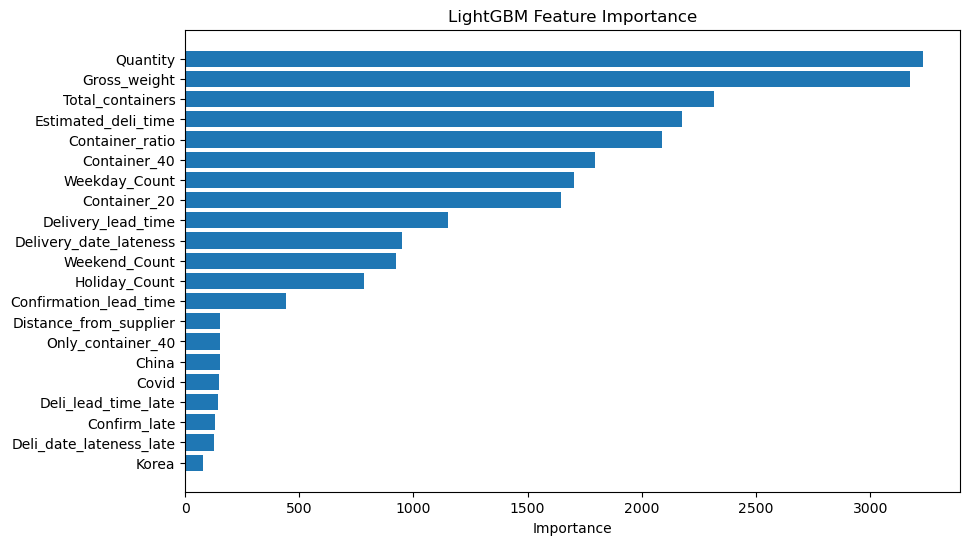

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance values
importances = best_model5.feature_importances_
feature_names = X_test.columns  # Ensure this matches your test data

# Create a DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame
print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()  # Puts the highest importance at the top
plt.show()

